In [196]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
from numpy.random import shuffle

In [2]:
def findInterval(T):
    min_a = 0
    max_b = 100

    low, high = 0, 0
    while (low == high):
        ab = np.random.randint(min_a, max_b , size=2)
        low, high = T*min(ab)/(max_b-min_a), T*max(ab)/(max_b-min_a)
#         print(min(ab), max(ab))
    return low, high

In [239]:
f = 40
T = 1/f
w = 2*np.pi*f
A = 1

n_features = 10
n_train_samples = 5000

X_train = np.zeros((n_train_samples, n_features))
y_train = np.zeros((n_train_samples, n_features))

for i in range(n_train_samples):
    t1, t2 = findInterval(T)
    t = np.linspace(t1, t2, n_features)
    X_train[i] = A*np.sin(w*t)
    y_train[i] = A*np.cos(w*t)

inputs = torch.from_numpy(X_train.reshape((n_train_samples, n_features, -1))).float()
print('Size of inputs: ', inputs.size())
targets = torch.from_numpy(y_train.reshape((n_train_samples, n_features, -1))).float()
print('Size of targets: ', targets.size())


Size of inputs:  torch.Size([5000, 10, 1])
Size of targets:  torch.Size([5000, 10, 1])


In [224]:
t = np.linspace(0,T, 70000)
xsin = np.sin(w*t).reshape(-1,10,1)
ycos = np.cos(w*t).reshape(-1,10,1)

shuffle(xsin)
shuffle(ysin)

inputs = torch.from_numpy(xsin).float()
targets = torch.from_numpy(ycos).float()

print(inputs.size(), targets.size())

torch.Size([7000, 10, 1]) torch.Size([7000, 10, 1])


In [244]:
is_cuda = torch.cuda.is_available()

if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")
    
print(device)

GPU is available
cuda


In [240]:
class Modelo(nn.Module):
    
    def __init__(self):
        super(Modelo, self).__init__()
        self.rnn = nn.RNN(input_size=10, 
                   hidden_size=10, batch_first=True)
        
    def forward(self, x, hidden):
#         print(x.size())
#       (batch_size , sequence_length , input_size)
        x = x.view(1, 1, 10)
        
        
        out, hidden = self.rnn(x, hidden)
#         print('before view out size:', out.size())
        out = out.view(-1)
#         print('after view out size:', out.size())

        
        return hidden, out
    
    def init_hidden(self):
        
#       (num_layers*num_directions , batch , hidden_size)
        return Variable(torch.zeros(1, 1, 10))
    

In [242]:
device = 'cpu'
model = Modelo().to(device)

criterion = torch.nn.MSELoss()
optimizer =torch.optim.SGD(model.parameters(), lr=5e-4)

n_epochs = 50
for epoch in range(n_epochs):
    
    model.train()
    
    hidden = model.init_hidden()
    loss = 0.0
    for input, target in zip(inputs, targets):
    
#       wrap in Variable
        input, target = Variable(input.to(device)), Variable(target.view(-1).to(device))
        
#       feed the input and acquire the output from network
        hidden, output = model(input, hidden)
    
#       calculating the predicted and the expected loss
        loss += criterion(output.float(), target.float())
    
#   clear the gradient
    optimizer.zero_grad()
        
#   compute the gradient
    loss.backward()

#   update the parameters
    optimizer.step()     
       
    print("epoch: %d, loss: %1.3f" % (epoch + 1, loss.data/n_train_samples))
    
    


epoch: 1, loss: 0.707
epoch: 2, loss: 0.338
epoch: 3, loss: 0.309
epoch: 4, loss: 0.262
epoch: 5, loss: 0.248
epoch: 6, loss: 0.210
epoch: 7, loss: 0.195
epoch: 8, loss: 0.187
epoch: 9, loss: 0.183
epoch: 10, loss: 0.179
epoch: 11, loss: 0.175
epoch: 12, loss: 0.166
epoch: 13, loss: 0.160
epoch: 14, loss: 0.155
epoch: 15, loss: 0.151
epoch: 16, loss: 0.147
epoch: 17, loss: 0.144
epoch: 18, loss: 0.141
epoch: 19, loss: 0.139
epoch: 20, loss: 0.137
epoch: 21, loss: 0.134
epoch: 22, loss: 0.133
epoch: 23, loss: 0.131
epoch: 24, loss: 0.129
epoch: 25, loss: 0.128
epoch: 26, loss: 0.126
epoch: 27, loss: 0.125
epoch: 28, loss: 0.123
epoch: 29, loss: 0.122
epoch: 30, loss: 0.121
epoch: 31, loss: 0.120
epoch: 32, loss: 0.119
epoch: 33, loss: 0.118
epoch: 34, loss: 0.117
epoch: 35, loss: 0.116
epoch: 36, loss: 0.115
epoch: 37, loss: 0.114
epoch: 38, loss: 0.113
epoch: 39, loss: 0.113
epoch: 40, loss: 0.112
epoch: 41, loss: 0.111
epoch: 42, loss: 0.110
epoch: 43, loss: 0.110
epoch: 44, loss: 0.1

torch.Size([10, 1]) torch.Size([10, 1])


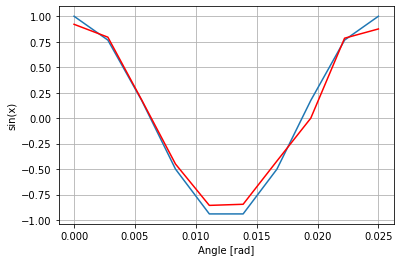

0.27937254

In [243]:
t = np.linspace(0, T, n_features)

test_sin = torch.from_numpy(np.sin(w*t)).reshape((1, n_features, -1)).float()
test_cos = torch.from_numpy(np.cos(w*t)).reshape((1, n_features, -1)).float()
hid = model.init_hidden()

for input, target in zip(test_sin, test_cos):
    print(input.size(), target.size())
    model.eval()
    
    with torch.no_grad():
        hid, out = model(Variable(input), model.init_hidden())
    
plt.plot(t, test_cos.view(-1))
plt.plot(t, out.view(-1), color = 'r')
plt.xlabel('Angle [rad]')
plt.ylabel('sin(x)')
plt.axis('tight')
plt.grid()
plt.show()

# plt.plot(t, out.view(-1))
# plt.xlabel('Angle [rad]')
# plt.ylabel('sin(x)')
# plt.axis('tight')
# plt.grid()
# plt.show()

np.linalg.norm(out.view(-1) - test_cos.view(-1))



    
    